# Heat-exchanger data analysis

## Cristian Merli - UniTn id: 211384

### Software header (info)

### Useful links

https://code.visualstudio.com/docs/datascience/data-science-tutorial

In [201]:
__author__ = "Cristian Merli"
__copyright__ = "Copyright 2021, The Cogent Project"
__credits__ = ["Cristian Merli", "Ing. Maurizio Grigiante"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Cristian Merli"
__email__ = "cristian.merli@studenti.unitn.it"
__status__ = "Draft"

### Libraries import

In [202]:
import fileinput as fi                                                                                  # File management lib
import pandas as pd                                                                                     # Data-analysis panda lib
import numpy as np                                                                                      # Data-analysis numpy lib
import seaborn as sns                                                                                   # Seaborn plottin' lib
import matplotlib.pyplot as plt                                                                         # Math plottin' lib

### Dataset vars

* Dataset file: original (.dat) file and formatted (.csv) file

In [203]:
dat_data_filepath = "../dataset/scambiatore26112021_5.dat"                                              # Original dataset filepath (.dat)
csv_data_filepath = "../dataset/scambiatore26112021_5.csv"                                              # Formatted dataset filepath (generate new .csv file)

* Modifications to perform while converting and formatting (.dat) file into (.csv) file

In [204]:
old_sep_chr = '\t'                                                                                      # Sep chr in (.dat) file
new_sep_chr = ';'                                                                                       # Sep chr in (.csv) file
comments_str = "% "                                                                                     # Delete comment-strings in (.dat) file when creatin' (.csv) file
oth_op_old_lbl = "Altra operazione"                                                                     # Replace 'other oper' lbl

* Heat-exchanger operation labels

In [205]:
oth_op_lbl = "Altra-operazione"                                                                         # Other oper lbl
cocurrent_flow_lbl = "Equicorrente"                                                                     # Cocurrent flow lbl
countercurrent_flow_lbl = "Controcorrente"                                                              # Countercurrent flow lbl

* Dataset columns

In [206]:
time_col = "Time(s)"                                                                                    # Time col in dataset (time ellapsed vals [s])
f1_col = "F1(l/h)"                                                                                      # Volume flow rate 1 col in dataset (cold fluid volume flow rate vals [l/h])
f2_col = "F2(l/h)"                                                                                      # Volume flow rate 2 col in dataset (hot fluid volume flow rate vals [l/h])
t1_col = "T1(degC)"                                                                                     # Temp 1 col in dataset (cold-in fluid temp vals [°C])
t2_col = "T2(degC)"                                                                                     # Temp 2 col in dataset (hot-in fluid temp vals [°C])
t3_col = "T3(degC)"                                                                                     # Temp 3 col in dataset (cold-out fluid temp vals [°C])
t4_col = "T4(degC)"                                                                                     # Temp 4 col in dataset (hot-out fluid temp vals [°C])
conf_col = "Configurazione"                                                                             # Config col in dataset

### Dataset formatting, import and plot

* Convert and format dataset: open and manipulate data in (.dat) file, writing formatted data inside (.csv) file

In [207]:
with open(dat_data_filepath,'r') as src_fl:                                                             # Open src file in read mode: (.dat) file
  with open(csv_data_filepath,'w') as dest_fl:                                                          # Open dest file in write mode: (.csv) file
      next(src_fl)                                                                                      # Skip header line in src file
      for line in src_fl:                                                                               # Read src file line-by-line
          line = line.replace(oth_op_old_lbl, oth_op_lbl)                                               # Replace target string (other operation label)
          line = line.replace(old_sep_chr, new_sep_chr)                                                 # Replace data separator-chars
          line = line.replace(comments_str, '')                                                         # Delete target string (comment string in src file)
          dest_fl.write(line)                                                                           # Write each formatted data line inside dest file (.csv)

* Import dataset data from formatted (.csv) file, creating a 'DataFrame' variable

In [208]:
he_data = pd.read_csv(csv_data_filepath, sep=new_sep_chr, encoding='utf8')                              # Import data in (.csv) dataset and create a new panda (lib) DataFrame variable: 'he_data'

* Plot data in DataFrame 'he_data' variable: temperatures and volume flow rates, taken during LabView data-acquisition on heat-exchanger

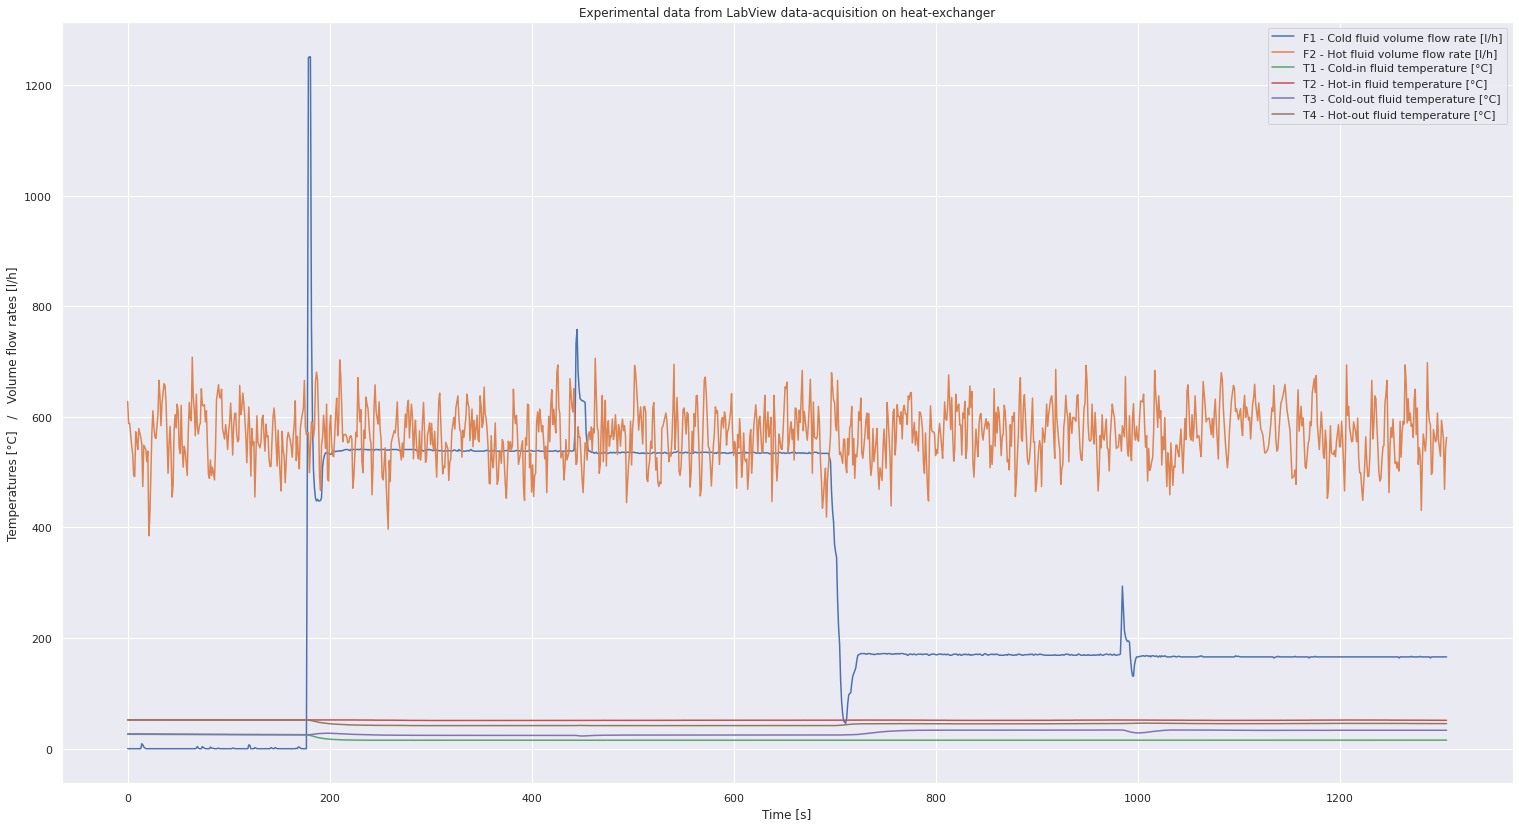

In [209]:
plt.title('Experimental data from LabView data-acquisition on heat-exchanger')                          # Plot title
plt.xlabel("Time [s]")                                                                                  # X-axis lbl
plt.ylabel("Temperatures [°C]   /   Volume flow rates [l/h]")                                           # Y-axis lbl
sns.set(rc={'figure.figsize':(26,14)})                                                                  # Plottin' size
sns.lineplot(x=time_col, y=f1_col, data=he_data, label='F1 - Cold fluid volume flow rate [l/h]')        # Cold fluid vol flow rate (F1)
sns.lineplot(x=time_col, y=f2_col, data=he_data, label='F2 - Hot fluid volume flow rate [l/h]')         # Hot fluid vol flow rate (F2)
sns.lineplot(x=time_col, y=t1_col, data=he_data, label='T1 - Cold-in fluid temperature [°C]')           # Cold-in fluid temp (T1)
sns.lineplot(x=time_col, y=t2_col, data=he_data, label='T2 - Hot-in fluid temperature [°C]')            # Hot-in fluid temp (T2)
sns.lineplot(x=time_col, y=t3_col, data=he_data, label='T3 - Cold-out fluid temperature [°C]')          # Cold-out fluid temp (T3)
sns.lineplot(x=time_col, y=t4_col, data=he_data, label='T4 - Hot-out fluid temperature [°C]');          # Hot-out fluid temp (T4)

### Data extraction and filtering

* Data intervals detection: extract data in different operating conditions, excluding eventual 'other-operation' values

In [210]:
delim_idxs = [0] * 8                                                                                    # Delimiter-indexes array (array containing 8 dataframe row idxs - configurations start/end idxs)
arr_cell_ptr = 0                                                                                        # Delimiter-indexes array cells pointer (to access array cells vals)
rows_scroll_index = 0                                                                                   # Index to trace current row in dataframe rows scrolling cycle
old_oper_str = ""                                                                                       # Operation string in previous dataframe row
oper_str = ""                                                                                           # Operation string in current dataframe row

for rows_scroll_index, row in he_data.iterrows():                                                       # Cycle to scroll rows in dataframe, tracing row index
    old_oper_str = oper_str                                                                             # Update previous dataframe row string
    oper_str = row[conf_col]                                                                            # Update current dataframe row string
    if (rows_scroll_index > 1):                                                                         # Skip first row (previous and current dataframe row strings are initialized with the same val)
        if ((old_oper_str == oth_op_lbl) & (oper_str == cocurrent_flow_lbl)):                           # Cocurrent flow configuration start detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val
        if ((old_oper_str == cocurrent_flow_lbl) & (oper_str == oth_op_lbl)):                           # Cocurrent flow configuration end detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index (+1 for data split) in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val
        if ((old_oper_str == oth_op_lbl) & (oper_str == countercurrent_flow_lbl)):                      # Countercurrent flow configuration start detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val
        if ((old_oper_str == countercurrent_flow_lbl) & (oper_str == oth_op_lbl)):                      # Countercurrent flow configuration end detecting condition
            delim_idxs[arr_cell_ptr] = rows_scroll_index                                                # Insert current row index (+1 for data split) in delimiter-indexes array
            arr_cell_ptr += 1                                                                           # Update delimiter-indexes array cells pointer val

if (delim_idxs[7] == 0):                                                                                # In case last configuration lasts 'till dataframe tail row
    delim_idxs[7] = rows_scroll_index+1                                                                 # Set last configuration end idx as tail row idx inside delimiter-idxs array (+1 for data split)

he_data_cocurr1 = he_data[delim_idxs[0]:delim_idxs[1]]                                                  # Extract cocurrent measure 1 (btwn 1st and 2nd index in delimiter-indexes array)
he_data_countercurr1 = he_data[delim_idxs[2]:delim_idxs[3]]                                             # Extract countercurrent measure 1 (btwn 3rd and 4th index in delimiter-indexes array)
he_data_countercurr2 = he_data[delim_idxs[4]:delim_idxs[5]]                                             # Extract countercurrent measure 2 (btwn 5th and 6th index in delimiter-indexes array)
he_data_cocurr2 = he_data[delim_idxs[6]:delim_idxs[7]]                                                  # Extract cocurrent measure 2 (btwn 6th and 7th index in delimiter-indexes array)

he_data_cocurr1 = he_data_cocurr1[~he_data_cocurr1[conf_col].isin([oth_op_lbl])]                        # Remove eventual data corresponding to other-operation in heat-exchanger data cocurrent 1
he_data_countercurr1 = he_data_countercurr1[~he_data_countercurr1[conf_col].isin([oth_op_lbl])]         # Remove eventual data corresponding to other-operation in heat-exchanger data countercurrent 1
he_data_countercurr2 = he_data_countercurr2[~he_data_countercurr2[conf_col].isin([oth_op_lbl])]         # Remove eventual data corresponding to other-operation in heat-exchanger data countercurrent 1
he_data_cocurr2 = he_data_cocurr2[~he_data_cocurr2[conf_col].isin([oth_op_lbl])]                        # Remove eventual data corresponding to other-operation in heat-exchanger data cocurrent 2

* Find optimal steady conditions calulating mean std-dev

In [232]:
datablocks_span = 30                                                                                    # Datablocks span [samples]

datablock = he_data_cocurr1                                                                             # Datablock to split
datablocks = list()                                                                                     # Datablocks list
num_datablocks = len(datablock) // datablocks_span                                                      # Datablocks list size (zero-idx)
max_idx = datablock.index[-1]-datablock.index[0]                                                        # Max datablock dataframe idx
for i in range(num_datablocks, 0, -1):                                                                  # -
  datablocks.append(datablock[max_idx-((i-1)*datablocks_span)-datablocks_span:max_idx-((i-1)*datablocks_span)+1])  # -
  # print(max_idx-((i-1)*datablocks_span)-datablocks_span, ':', max_idx-((i-1)*datablocks_span))
datablocks[5]

# he_data_cocurr1[f1_col].std()
# he_data_cocurr1[f2_col].std()
# he_data_cocurr1[t1_col].std()
# he_data_cocurr1[t2_col].std()
# he_data_cocurr1[t3_col].std()
# he_data_cocurr1[t4_col].std()

# he_data_countercurr1[f1_col].std()
# he_data_countercurr1[f2_col].std()
# he_data_countercurr1[t1_col].std()
# he_data_countercurr1[t2_col].std()
# he_data_countercurr1[t3_col].std()
# he_data_countercurr1[t4_col].std()

# he_data_countercurr2[f1_col].std()
# he_data_countercurr2[f2_col].std()
# he_data_countercurr2[t1_col].std()
# he_data_countercurr2[t2_col].std()
# he_data_countercurr2[t3_col].std()
# he_data_countercurr2[t4_col].std()

# he_data_cocurr2[f1_col].std()
# he_data_cocurr2[f2_col].std()
# he_data_cocurr2[t1_col].std()
# he_data_cocurr2[t2_col].std()
# he_data_cocurr2[t3_col].std()
# he_data_cocurr2[t4_col].std()

26 : 56
56 : 86
86 : 116
116 : 146
146 : 176
176 : 206


,Time(s),F1(l/h),F2(l/h),T1(degC),T2(degC),T3(degC),T4(degC),Configurazione
371,399,539,534,15.34,51.02,24.23,41.64,Equicorrente
372,400,539,464,15.34,51.02,24.23,41.64,Equicorrente
373,401,538,513,15.34,51.13,24.23,41.74,Equicorrente
374,402,538,456,15.24,51.02,24.13,41.74,Equicorrente
375,403,538,494,15.34,51.13,24.23,41.64,Equicorrente
376,404,538,498,15.24,51.02,24.13,41.74,Equicorrente
377,405,539,591,15.34,51.02,24.13,41.64,Equicorrente
378,406,539,609,15.24,51.13,24.13,41.74,Equicorrente
379,407,539,573,15.24,51.02,24.13,41.64,Equicorrente
380,408,538,614,15.24,51.13,24.23,41.74,Equicorrente


* Tmp plots

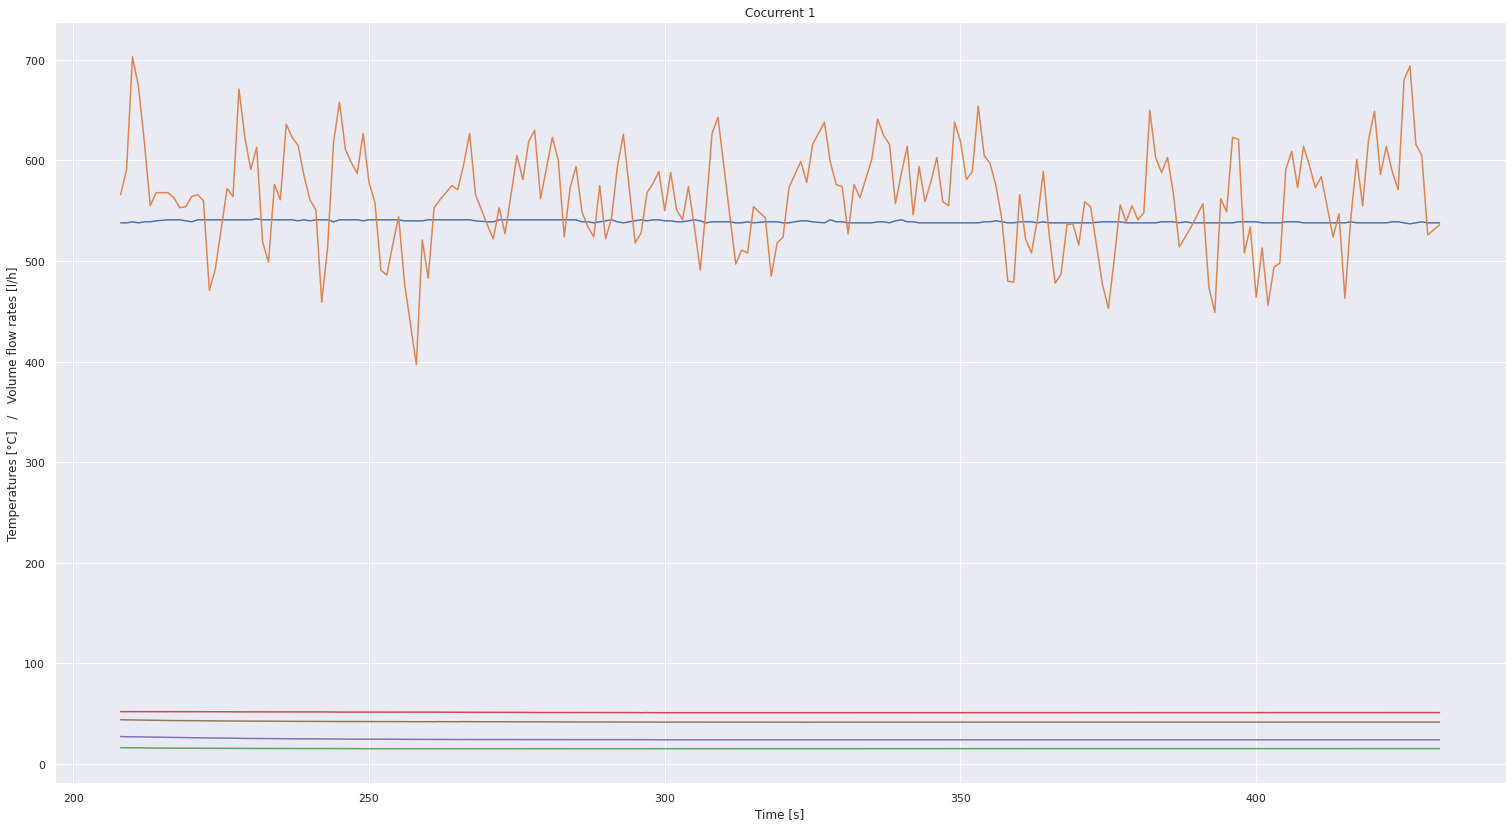

In [212]:
plt.title('Cocurrent 1')                                                                                # Plot title
plt.xlabel("Time [s]")                                                                                  # X-axis lbl
plt.ylabel("Temperatures [°C]   /   Volume flow rates [l/h]")                                           # Y-axis lbl
sns.set(rc={'figure.figsize':(26,14)})                                                                  # Plottin' size
sns.lineplot(x=time_col, y=f1_col, data=he_data_cocurr1)                                                # Cold fluid vol flow rate (F1)
sns.lineplot(x=time_col, y=f2_col, data=he_data_cocurr1)                                                # Hot fluid vol flow rate (F2)
sns.lineplot(x=time_col, y=t1_col, data=he_data_cocurr1)                                                # Cold-in fluid temp (T1)
sns.lineplot(x=time_col, y=t2_col, data=he_data_cocurr1)                                                # Hot-in fluid temp (T2)
sns.lineplot(x=time_col, y=t3_col, data=he_data_cocurr1)                                                # Cold-out fluid temp (T3)
sns.lineplot(x=time_col, y=t4_col, data=he_data_cocurr1);                                               # Hot-out fluid temp (T4)

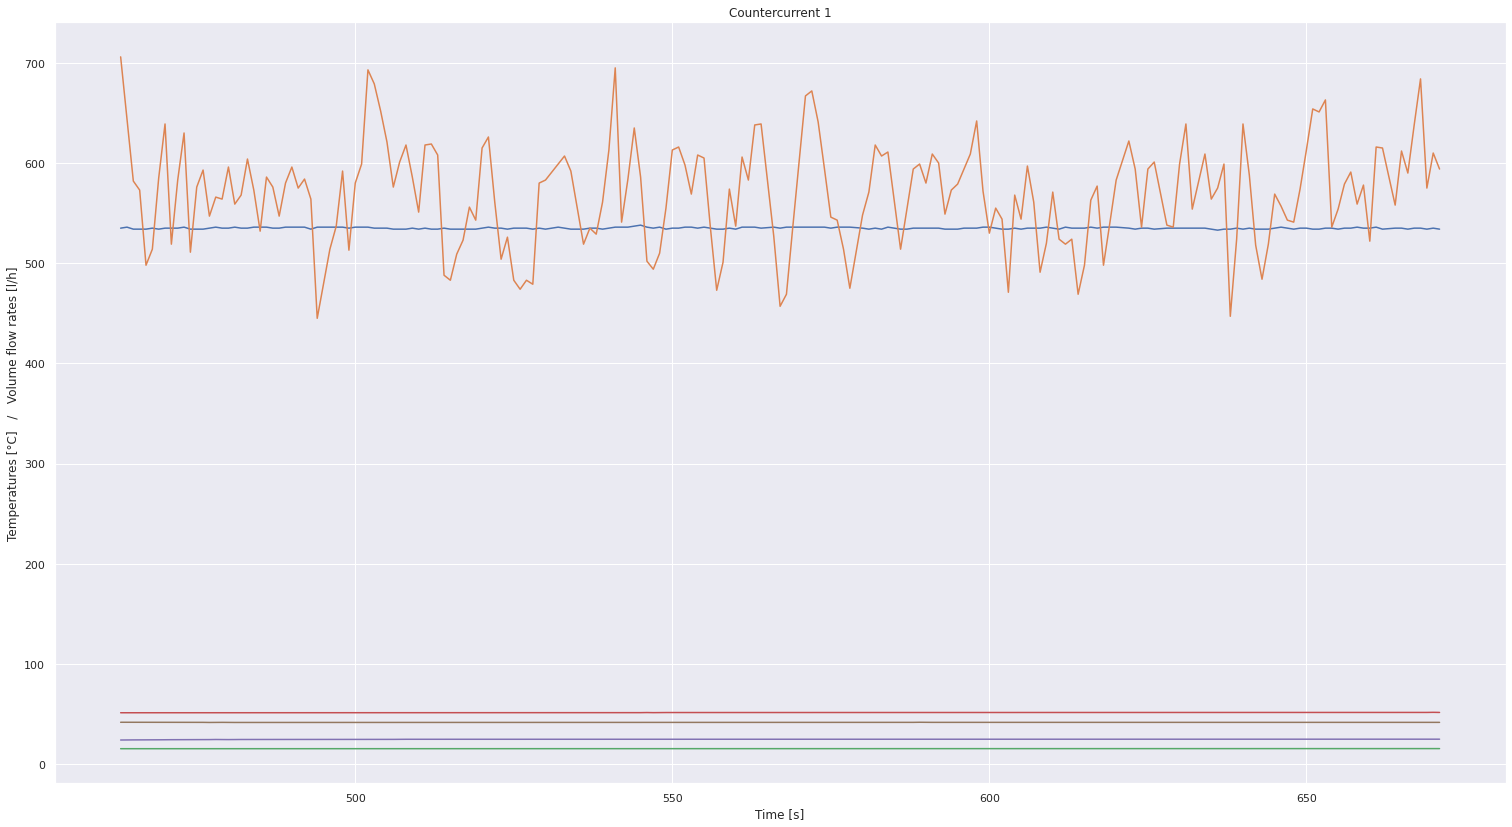

In [213]:
plt.title('Countercurrent 1')                                                                           # Plot title
plt.xlabel("Time [s]")                                                                                  # X-axis lbl
plt.ylabel("Temperatures [°C]   /   Volume flow rates [l/h]")                                           # Y-axis lbl
sns.set(rc={'figure.figsize':(26,14)})                                                                  # Plottin' size
sns.lineplot(x=time_col, y=f1_col, data=he_data_countercurr1)                                           # Cold fluid vol flow rate (F1)
sns.lineplot(x=time_col, y=f2_col, data=he_data_countercurr1)                                           # Hot fluid vol flow rate (F2)
sns.lineplot(x=time_col, y=t1_col, data=he_data_countercurr1)                                           # Cold-in fluid temp (T1)
sns.lineplot(x=time_col, y=t2_col, data=he_data_countercurr1)                                           # Hot-in fluid temp (T2)
sns.lineplot(x=time_col, y=t3_col, data=he_data_countercurr1)                                           # Cold-out fluid temp (T3)
sns.lineplot(x=time_col, y=t4_col, data=he_data_countercurr1);                                          # Hot-out fluid temp (T4)

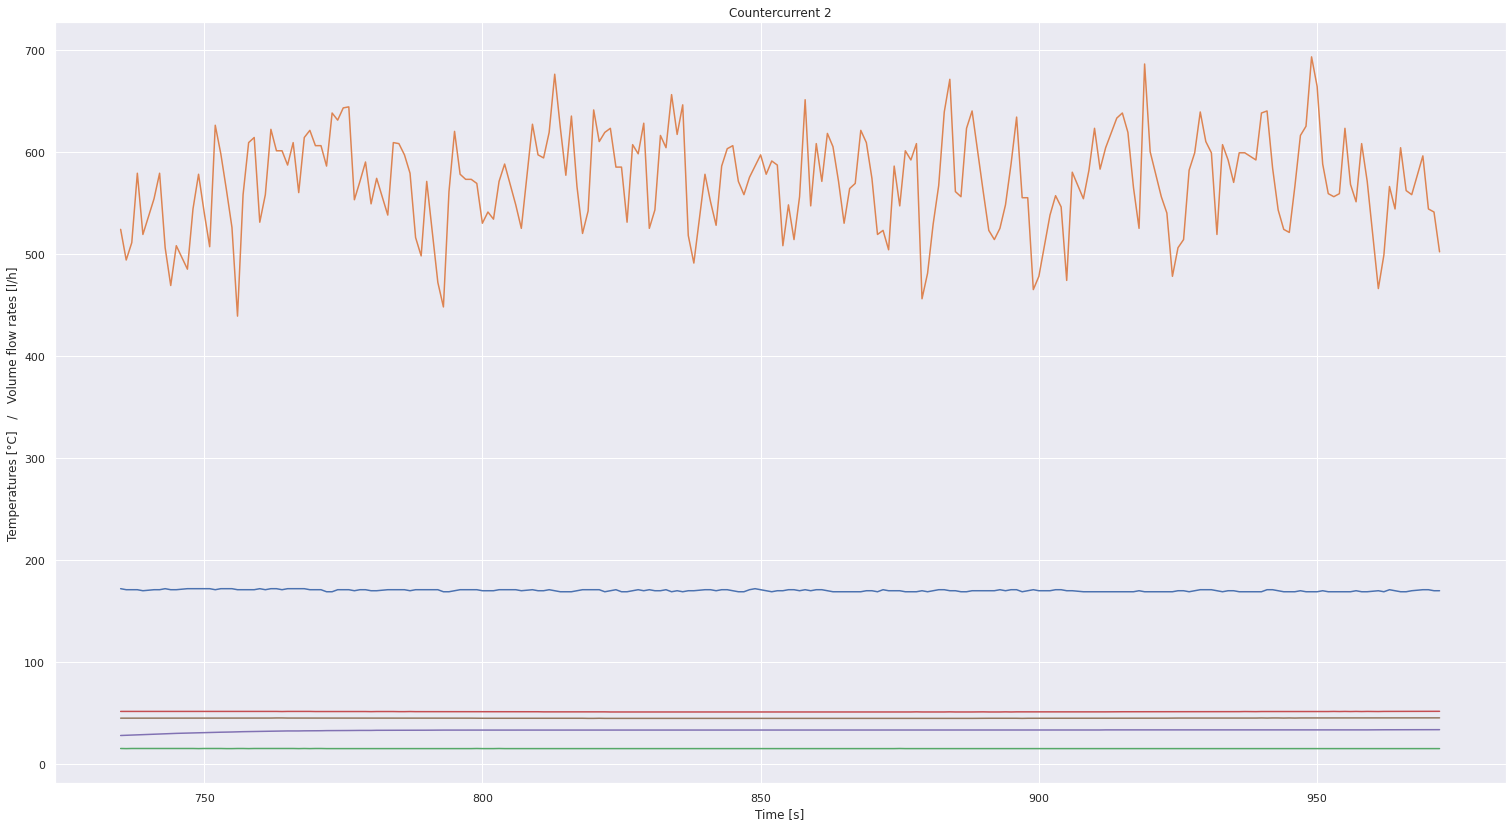

In [214]:
plt.title('Countercurrent 2')                                                                           # Plot title
plt.xlabel("Time [s]")                                                                                  # X-axis lbl
plt.ylabel("Temperatures [°C]   /   Volume flow rates [l/h]")                                           # Y-axis lbl
sns.set(rc={'figure.figsize':(26,14)})                                                                  # Plottin' size
sns.lineplot(x=time_col, y=f1_col, data=he_data_countercurr2)                                           # Cold fluid vol flow rate (F1)
sns.lineplot(x=time_col, y=f2_col, data=he_data_countercurr2)                                           # Hot fluid vol flow rate (F2)
sns.lineplot(x=time_col, y=t1_col, data=he_data_countercurr2)                                           # Cold-in fluid temp (T1)
sns.lineplot(x=time_col, y=t2_col, data=he_data_countercurr2)                                           # Hot-in fluid temp (T2)
sns.lineplot(x=time_col, y=t3_col, data=he_data_countercurr2)                                           # Cold-out fluid temp (T3)
sns.lineplot(x=time_col, y=t4_col, data=he_data_countercurr2);                                          #  Hot-out fluid temp (T4)

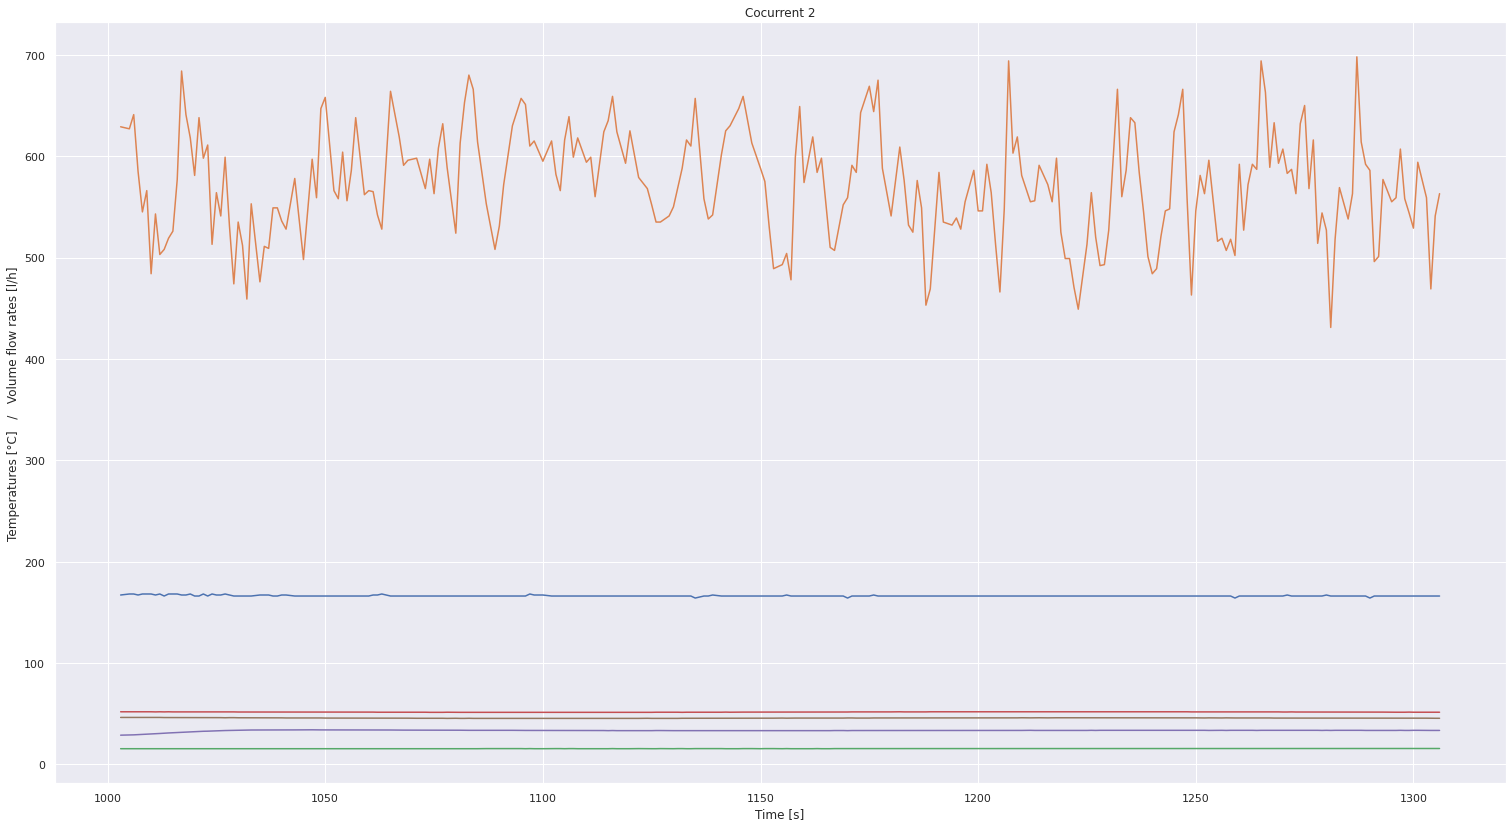

In [215]:
plt.title('Cocurrent 2')                                                                                # Plot title
plt.xlabel("Time [s]")                                                                                  # X-axis lbl
plt.ylabel("Temperatures [°C]   /   Volume flow rates [l/h]")                                           # Y-axis lbl
sns.set(rc={'figure.figsize':(26,14)})                                                                  # Plottin' size
sns.lineplot(x=time_col, y=f1_col, data=he_data_cocurr2)                                                # Cold fluid vol flow rate (F1)
sns.lineplot(x=time_col, y=f2_col, data=he_data_cocurr2)                                                # Hot fluid vol flow rate (F2)
sns.lineplot(x=time_col, y=t1_col, data=he_data_cocurr2)                                                # Cold-in fluid temp (T1)
sns.lineplot(x=time_col, y=t2_col, data=he_data_cocurr2)                                                # Hot-in fluid temp (T2)
sns.lineplot(x=time_col, y=t3_col, data=he_data_cocurr2)                                                # Cold-out fluid temp (T3)
sns.lineplot(x=time_col, y=t4_col, data=he_data_cocurr2);                                               # Hot-out fluid temp (T4)